In [1]:
import numpy as np 
import pandas as pd 
import cv2
from matplotlib import pyplot as plt

import os

def imageShow(img):
    plt.figure(figsize=(15,15))
    plt.imshow(img)
    plt.xticks([]),plt.yticks([])
    plt.show()

In [2]:

def selectQMatrix(qName):
    Quality_10 = np.array([ [80,60,50,80,120,200,255,255],
                            [55,60,70,95,130,255,255,255],
                            [70,65,80,120,200,255,255,255],
                            [70,85,110,145,255,255,255,255],
                            [90,110,185,255,255,255,255,255],
                            [120,175,255,255,255,255,255,255],
                            [245,255,255,255,255,255,255,255],
                            [255,255,255,255,255,255,255,255]])

    Quality_50 = np.array([ [16,11,10,16,24,40,51,61],
                            [12,12,14,19,26,58,60,55],
                            [14,13,16,24,40,57,69,56],
                            [14,17,22,29,51,87,80,62],
                            [18,22,37,56,68,109,103,77],
                            [24,35,55,64,81,104,113,92],
                            [49,64,78,87,103,121,120,101],
                            [72,92,95,98,112,100,130,99]])

    Quality_90 = np.array([ [3,2,2,3,5,8,10,12],
                            [2,2,3,4,5,12,12,11],
                            [3,3,3,5,8,11,14,11],
                            [3,3,4,6,10,17,16,12],
                            [4,4,7,11,14,22,21,15],
                            [5,7,11,13,16,12,23,18],
                            [10,13,16,17,21,24,24,21],
                            [14,18,19,20,22,20,20,20]])
    if qName == "10 percent":
        return Quality_10
    elif qName == "50 percent":
        return Quality_50
    elif qName == "90 percent":
        return Quality_90
    else:
        # just for returning original image..
        return np.ones((8,8)) 
    

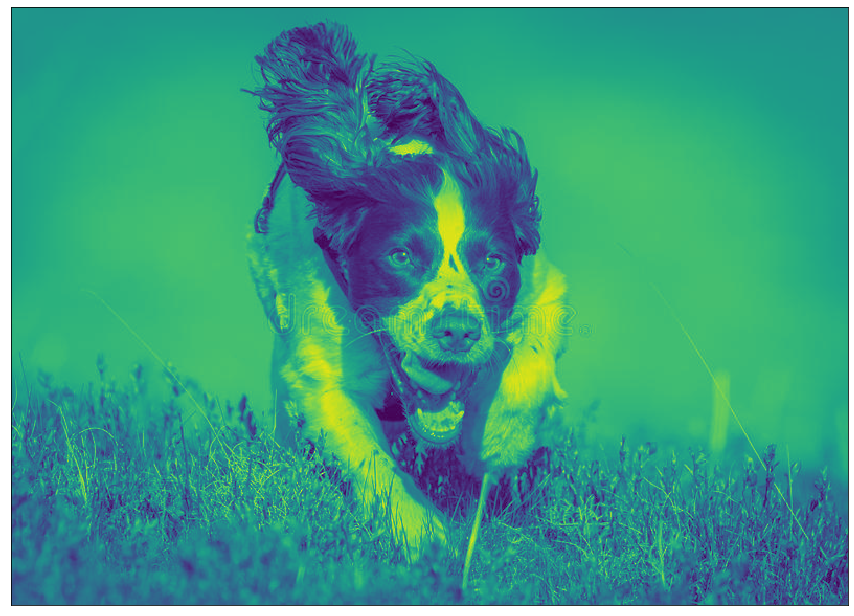

In [3]:
OurImage = 'dog.png'
img = cv2.imread(OurImage, 0)
imageShow(img)

In [4]:
h = len(img) 
w = len(img[0]) 
block_size = 8
print("height : ",h,", width :",w)

height :  572 , width : 800


In [5]:
blocks = []  
y = 0
for i in range(block_size, h+1, block_size):
    x = 0
    for j in range(block_size, w+1, block_size):
        blocks.append( img[y:i,x:j] - np.ones((8,8))*128 )
        # dct is done between [-128:127] but our image pixel range is from [0:255]
        x = j
    y = i
print("number of blocks "+ str(len(blocks)))
print("shape of each in blacks : ", blocks[0].shape)

number of blocks 7100
shape of each in blacks :  (8, 8)


In [6]:
# dct operaition in cv2 requires a float..
# converting int to float..
flt_blocks = [np.float32(i) for i in blocks]
print(len(flt_blocks))

7100


In [7]:
Dct = []
for i in flt_blocks:
    Dct.append(cv2.dct(i))


In [8]:
# compression matric selection according to compression rate..
# since we arent going to compress, our main objective is to hide info, so we need less number of zeros and ones..
# compression rate = 90%
# this step is called quantisation..

compMat = selectQMatrix("100 percent")
# print(compMat)
for block in Dct:
    for i in range(block_size):
        for j in range(block_size):
            block[i,j] = np.around( block[i,j] / compMat[i,j])
print(Dct[0:200])

# quantisation done..
# now we have to embed the binary data into the quantised image..

[array([[48.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32), array([[48.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32), array([[40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  

In [9]:
inv_blocks = []
for i in Dct:
    inv_blocks.append(cv2.idct(i))


    Normal Jpeg compressed image..


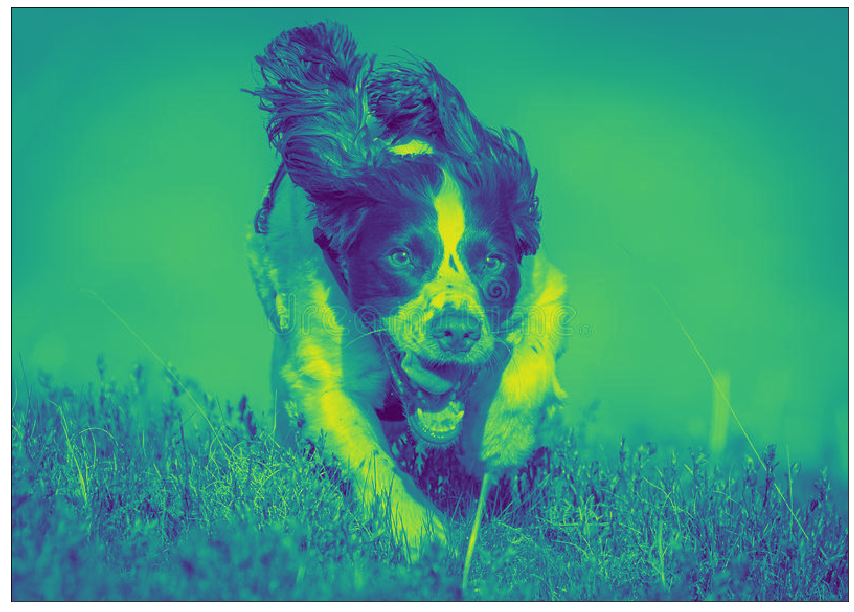

In [10]:
r = 0
rc = []
for i in range(int(w/block_size),len(inv_blocks)+1,int(w/block_size)):
    rc.append(np.hstack((inv_blocks[r:i])))
    r = i
res = np.vstack((rc))
print("    Normal Jpeg compressed image..")
imageShow(res)

In [11]:
def str_to_bin(txt_msg):
    res = []
    for c in txt_msg:
        f = ord(c)
        for i in range(8):
            if f & (1<<i) == (1<<i):
                res.append('1')
            else:
                res.append('0')
    assert(len(res)==8*len(txt_msg))
    return ''.join(res)

def put(bin_msg, Dct_blocks):
    # dct blocks are 8*8 --> in these blocks we have to embed our bin data..
    assert(Dct_blocks[0].shape == (block_size, block_size))
    ptr = 0 # boolean pointer for
    for block in Dct_blocks:
        for i in range(block_size):
            for j in range(block_size):
                if ptr >= len(bin_msg):
                    return Dct_blocks
                if block[i,j]!=0 and block[i,j]!=1:
                    f = int(block[i,j])
                    # only embedding one bit per 1 dct coeff..
                    if not ((bin_msg[ptr]=='1' and f & 1 == 1) or (bin_msg[ptr]=='0' and f & 1 == 0)):
                        if f&1 == 1:
                            block[i,j]-=1
                        else :
                            block[i,j]+=1
                    ptr+=1
    return Dct_blocks

def invDct(Dct):
    inv_blocks = []
    for i in Dct:
        inv_blocks.append(cv2.idct(i) + np.ones((8,8)) * 128)

    r = 0
    rc = []
    for i in range(int(w/block_size),len(inv_blocks)+1,int(w/block_size)):
        rc.append(np.hstack((inv_blocks[r:i])))
        r = i
    res = np.vstack((rc))
    imageShow(res)
    return res


import copy

def Last_1_bit(f_img):
    bwImg = copy.deepcopy(f_img)
    w = len(bwImg[0])
    h = len(bwImg)
    for i in range(h):
        for j in range(w):
            f = int(bwImg[i,j])
            bwImg[i,j] = (255 * (f&1))
    return bwImg

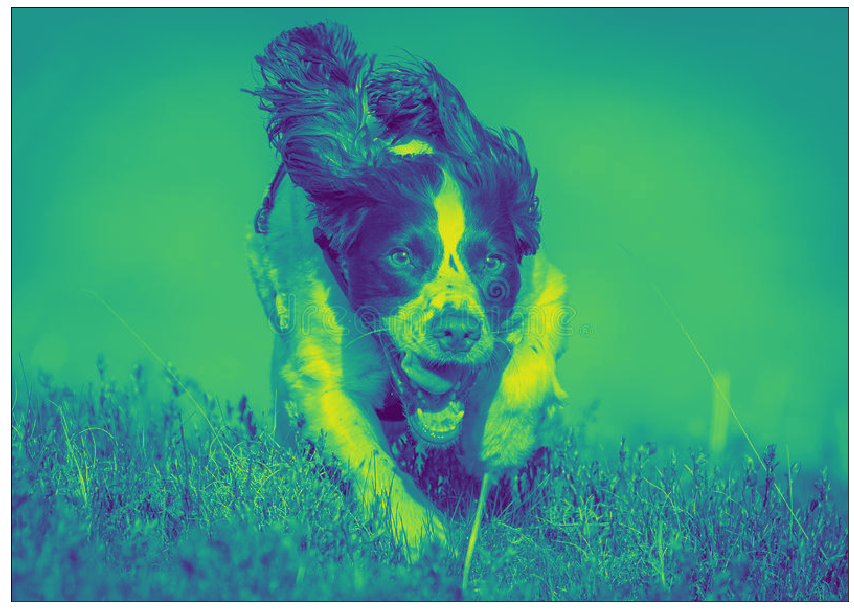

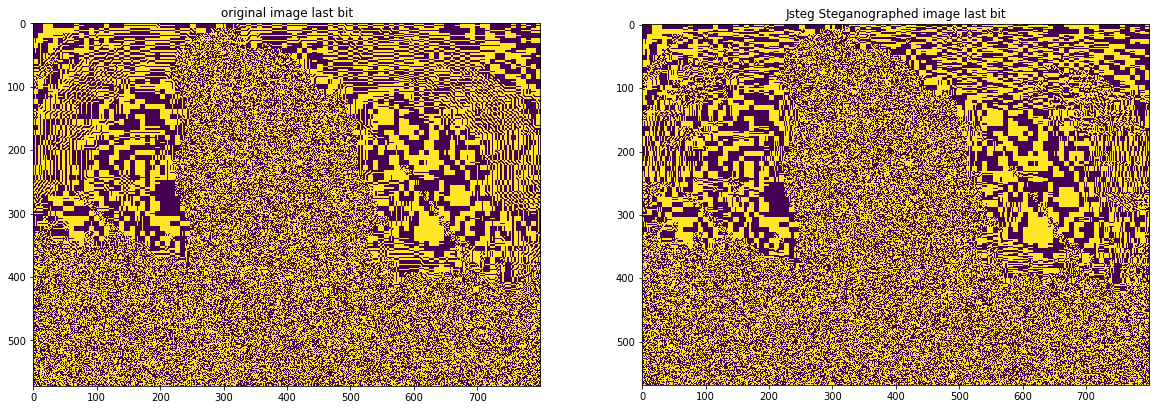

In [15]:
file = open("testFile.txt","r+")  
binTxt = ""
binTxt = file.read()
binTxt = str_to_bin(binTxt)
# print(binTxt)

put(binTxt, Dct)

final_Img = invDct(Dct)


last = Last_1_bit(final_Img)
first = Last_1_bit(img)

f, axarr = plt.subplots(1,2)
f.set_figheight(20)
f.set_figwidth(20)
axarr[0].imshow(first)
axarr[0].title.set_text("original image last bit")
axarr[1].imshow(last)
axarr[1].title.set_text("Jsteg Steganographed image last bit")
plt.show()